#Understanding the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Load data
energy_df = pd.read_csv('../Data/energy_dataset.csv', parse_dates=['time'])
weather_df = pd.read_csv('../Data/weather_features.csv', parse_dates=['dt_iso'])

print(f"Energy: {energy_df.shape}")
print(f"Weather: {weather_df.shape}")

Energy: (35064, 29)
Weather: (178396, 17)


In [5]:
# Columns
print("ENERGY COLUMNS:")
print(energy_df.columns.tolist())
print("\n-------------------\n")
print("WEATHER COLUMNS:")
print(weather_df.columns.tolist())

ENERGY COLUMNS:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']

-------------------

WEATHER COLUMNS:
['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'sn

In [8]:
# Missing values in energy data
energy_df.isnull().sum().sort_values(ascending=False).head(10)


generation hydro pumped storage aggregated     35064
forecast wind offshore eday ahead              35064
total load actual                                 36
generation hydro run-of-river and poundage        19
generation hydro pumped storage consumption       19
generation waste                                  19
generation marine                                 19
generation fossil oil                             19
generation biomass                                19
generation fossil peat                            18
dtype: int64

In [9]:

# Missing values in weather data
weather_df.isnull().sum().sort_values(ascending=False).head(10)

dt_iso        0
city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
dtype: int64

In [10]:
# Data Cleansing 

# Drop useless columns
energy_df = energy_df.drop(columns=[
    'generation hydro pumped storage aggregated',
    'forecast wind offshore eday ahead'
])

# Drop rows where total load actual is missing (only 36 rows)
energy_df = energy_df.dropna(subset=['total load actual'])

print(f"Energy after cleaning: {energy_df.shape}")

Energy after cleaning: (35028, 27)


In [12]:
weather_df['city_name'].unique()

<StringArray>
['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville']
Length: 5, dtype: str

In [17]:
# Key energy metrics 
print(energy_df[['total load actual', 'price actual']].describe().round(1))
print("\n-------------------\n")
weather_df['temp_celsius'] = weather_df['temp'] -273.15
print(weather_df['temp_celsius'].describe().round(1))

       total load actual  price actual
count            35028.0       35028.0
mean             28696.9          57.9
std               4575.0          14.2
min              18041.0           9.3
25%              24807.8          49.4
50%              28901.0          58.0
75%              32192.0          68.0
max              41015.0         116.8

-------------------

count    178396.0
mean         16.5
std           8.0
min         -10.9
25%          10.5
50%          16.0
75%          22.0
max          42.5
Name: temp_celsius, dtype: float64


# EDA is more of less done at this point

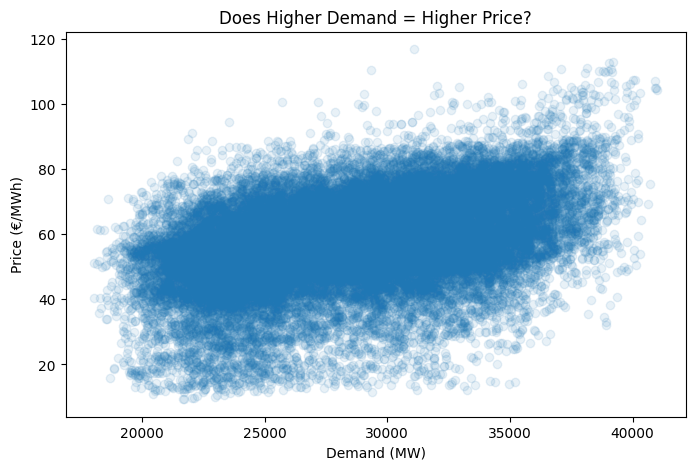

In [ ]:
#Price vs Demand (scatter plot)
plt.figure(figsize=(8, 5))
plt.scatter(energy_df['total load actual'], energy_df['price actual'], alpha=0.1)
plt.xlabel('Demand (MW)')
plt.ylabel('Price (€/MWh)')
plt.title('Does Higher Demand = Higher Price?')
plt.show()

In [ ]:
# Weather and Demand Analysis
# to understand if temperature affects electricity demand
weather_hourly = weather_df.groupby('dt_iso')['temp_celsius'].mean().reset_index()
weather_hourly.columns = ['time', 'avg_temp']

print(weather_hourly.shape)
print(weather_hourly.head())


(35064, 2)
                        time  avg_temp
0  2015-01-01 00:00:00+01:00 -0.658537
1  2015-01-01 01:00:00+01:00 -0.637300
2  2015-01-01 02:00:00+01:00 -1.050862
3  2015-01-01 03:00:00+01:00 -1.060531
4  2015-01-01 04:00:00+01:00 -1.004100


In [ ]:
# merging weather and energy based on timestamps similar how we join 2 tables in SQL

merged_df  = pd.merge(
    energy_df,
    weather_hourly,
    left_on='time',
    right_on='time',
    how='inner'
)

print(f"Merged shape: {merged_df.shape}")
print(merged_df[['time', 'total load actual', 'avg_temp']].head())

Merged shape: (35028, 28)
                        time  total load actual  avg_temp
0  2015-01-01 00:00:00+01:00            25385.0 -0.658537
1  2015-01-01 01:00:00+01:00            24382.0 -0.637300
2  2015-01-01 02:00:00+01:00            22734.0 -1.050862
3  2015-01-01 03:00:00+01:00            21286.0 -1.060531
4  2015-01-01 04:00:00+01:00            20264.0 -1.004100


In [ ]:
#checking the correlation from above
correlation = merged_df['avg_temp'].corr(merged_df['total load actual'])
print(f"Correlation: {correlation:.3f}")

#found the correlation to be 0.203, which doesn't makes much sense from a logical perspective
#from a bit of googling what I can see is correlation measures linear relationships whereas temp vs demand is different

Correlation: 0.203


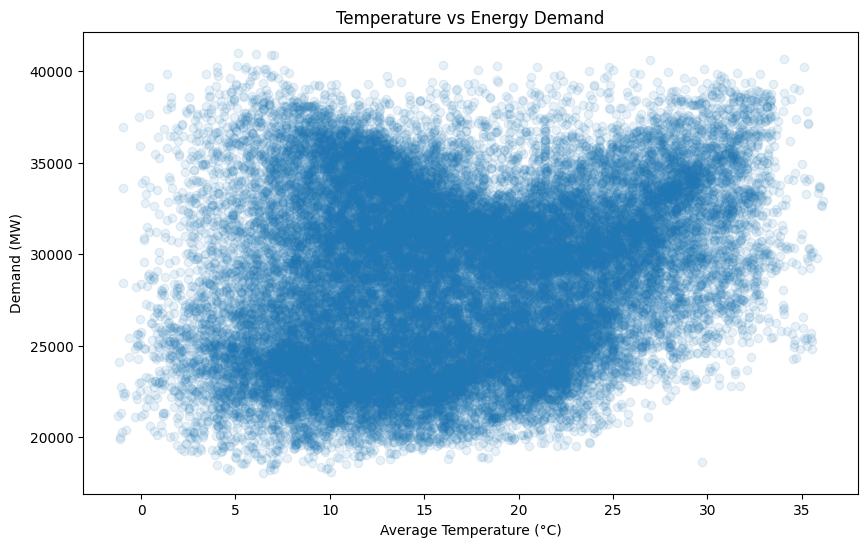

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['avg_temp'], merged_df['total load actual'], alpha=0.1)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Demand (MW)')
plt.title('Temperature vs Energy Demand')
plt.show()